<a id='top'> </a>
Author: [James Bourbeau](http://www.jamesbourbeau.com)

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,matplotlib,scipy,pandas,sklearn,mlxtend

last updated: 2017-03-22 

CPython 2.7.10
IPython 5.3.0

numpy 1.12.0
matplotlib 2.0.0
scipy 0.15.1
pandas 0.19.2
sklearn 0.18.1
mlxtend 0.5.1


# Cosmic-ray light component analysis
### Table of contents
1. [Define analysis free parameters](#Define-analysis-free-parameters)
1. [Data preprocessing](#Data-preprocessing)
2. [Fitting random forest](#Fit-random-forest-and-run-10-fold-CV-validation)
3. [Fraction correctly identified](#Fraction-correctly-identified)
4. [Spectrum](#Spectrum)
5. [Unfolding](#Unfolding)
6. [Feature importance](#Feature-importance)

In [2]:
from __future__ import division, print_function
from collections import defaultdict
import itertools
import numpy as np
from scipy import optimize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import pyprind
import multiprocessing as mp

from sklearn.model_selection import ShuffleSplit

import composition as comp
import composition.analysis.plotting as plotting
    
# color_dict allows for a consistent color-coding for each composition
color_dict = comp.analysis.get_color_dict()

%matplotlib inline

/home/jbourbeau/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Define analysis free parameters
[ [back to top](#top) ]

Whether or not to train on 'light' and 'heavy' composition classes, or the individual compositions

In [3]:
comp_class = True
comp_list = ['light', 'heavy'] if comp_class else ['P', 'He', 'O', 'Fe']

Get composition classifier pipeline

In [4]:
pipeline_str = 'GBDT'
pipeline = comp.get_pipeline(pipeline_str)

Define energy binning for this analysis

In [5]:
energybins = comp.analysis.get_energybins()

# Data preprocessing
[ [back to top](#top) ]
1. Load simulation/data dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets
4. Feature transformation

In [6]:
sim_train, sim_test = comp.preprocess_sim(comp_class=comp_class, return_energy=True)

sim quality cut event flow:
             IceTopQualityCuts:    1.0    1.0
         lap_InIce_containment:  0.776  0.776
              InIceQualityCuts:  0.786   0.75
                 num_hits_1_60:  0.999   0.75


Selecting the following features:
	$\cos(\theta_{\mathrm{Lap}})$
	$\log_{10}(S_{\mathrm{125}})$
	$\log_{10}$(dE/dX)
	
Number training events = 208926
Number testing events = 89540


In [7]:
splitter = ShuffleSplit(n_splits=1, test_size=.5, random_state=2)
for train_index, verification_index in splitter.split(sim_train.X):
    sim_verification = sim_train[verification_index]
    sim_train = sim_train[train_index]
print('Number of training events = {}'.format(len(sim_train)))
print('Number of verification events = {}'.format(len(sim_verification)))

Number of training events = 104463
Number of verification events = 104463


In [17]:
data = comp.preprocess_data(comp_class=comp_class, return_energy=True)

data quality cut event flow:
             IceTopQualityCuts:    1.0    1.0
         lap_InIce_containment:    1.0    1.0
             reco_energy_range:    1.0    1.0
                 num_hits_1_30:    1.0    1.0
                max_qfrac_1_30:    1.0    1.0
              InIceQualityCuts:  0.957  0.957


Selecting the following features:
	$\cos(\theta_{\mathrm{Lap}})$
	$\log_{10}(S_{\mathrm{125}})$
	$\log_{10}(InIce charge (top 50))$
	Charge/NChannels
	NHits/NChannels
	dE/dX (standard)
	
Number testing events = 2124113


Run classifier over training and testing sets to get an idea of the degree of overfitting

In [8]:
pipeline.fit(sim_train.X, sim_train.y)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impuri...ors=125, presort='auto', random_state=2,
              subsample=1.0, verbose=0, warm_start=False))])

In [9]:
fracs = defaultdict(list)
frac_array = np.arange(0.0, 1.1, 0.1)
for light_frac in frac_array:
    print('On light_frac = {}'.format(light_frac))
    for i in range(1000):
        heavy_frac = 1 - light_frac
        light_dataset = comp.analysis.get_random_subsample(sim_verification, frac=light_frac, composition='light')
        heavy_dataset = comp.analysis.get_random_subsample(sim_verification, frac=heavy_frac, composition='heavy')
        combined_dataset = light_dataset + heavy_dataset
        pred = pipeline.predict(combined_dataset.X)
        num_pred_light = np.sum(combined_dataset.le.inverse_transform(pred) == 'light')
        frac_light = num_pred_light/len(combined_dataset)
        fracs[light_frac].append(frac_light)

On light_frac = 0.0
On light_frac = 0.1
On light_frac = 0.2
On light_frac = 0.3
On light_frac = 0.4
On light_frac = 0.5
On light_frac = 0.6
On light_frac = 0.7
On light_frac = 0.8
On light_frac = 0.9
On light_frac = 1.0


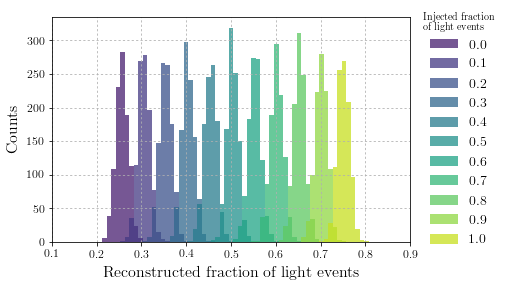

In [18]:
with sns.color_palette('viridis', len(frac_array)):
    fig, ax = plt.subplots()
    for light_frac in frac_array:
        sns.distplot(fracs[light_frac], bins=np.linspace(0.0, 1.0, 100),
                     kde=False, label=str(light_frac), hist_kws={'alpha': 0.75})
    ax.set_xlabel('Reconstructed fraction of light events')
    ax.set_ylabel('Counts')
    ax.set_xlim([0.1, 0.9])
    ax.grid()
    leg = plt.legend(title='Injected fraction\nof light events',
                     loc='center left', frameon=False,
              bbox_to_anchor=(1.0,  # horizontal
                              0.5),# vertical 
              ncol=1, fancybox=False)
    plt.savefig('/home/jbourbeau/public_html/figures/light-frac-reconstructed-hists.png')
    plt.show()

[0.25650000000000001, 0.30599999999999999, 0.35399999999999998, 0.40300000000000002, 0.45500000000000002, 0.504, 0.55355355355355351, 0.60260260260260257, 0.6526526526526526, 0.70170170170170165, 0.751]
[0.01404953180714575, 0.013699643207032808, 0.013575122982868329, 0.013832056933081201, 0.013972475657520394, 0.013070602740501307, 0.014200320861728425, 0.01428133705994826, 0.013349494927547875, 0.013707258697239395, 0.01361137314895159]


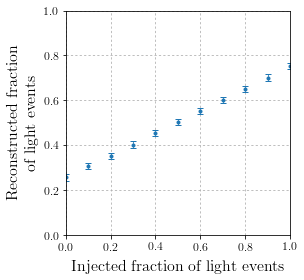

In [23]:
fig, ax = plt.subplots()
medians = []
errs = []
for light_frac in frac_array:
    medians.append(np.median(fracs[light_frac]))
    errs.append(np.std(fracs[light_frac]))
print(medians)
print(errs)
ax.errorbar(frac_array, medians, yerr=errs, marker='.', ls='None')
ax.set_xlabel('Injected fraction of light events')
ax.set_ylabel('Reconstructed fraction\nof light events')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_aspect(1.0)
ax.grid()
plt.savefig('/home/jbourbeau/public_html/figures/light-frac-reconstructed-medians.png')
plt.show()

In [22]:
n_samples = 10000
injected_frac = np.random.ranf(n_samples)
reco_frac = []
bar = pyprind.ProgBar(n_samples)
for light_frac in injected_frac:
    heavy_frac = 1 - light_frac
    light_dataset = comp.analysis.get_random_subsample(sim_verification, frac=light_frac, composition='light')
    heavy_dataset = comp.analysis.get_random_subsample(sim_verification, frac=heavy_frac, composition='heavy')
    combined_dataset = light_dataset + heavy_dataset
    pred = pipeline.predict(combined_dataset.X)
    num_pred_light = np.sum(combined_dataset.le.inverse_transform(pred) == 'light')
    frac_light = num_pred_light/len(combined_dataset)
    reco_frac.append(frac_light)
    bar.update()

0%                          100%
[##############################] | ETA: 00:02:52 | ETA: 00:02:33 | ETA: 00:02:49 | ETA: 00:02:56 | ETA: 00:02:49 | ETA: 00:02:35 | ETA: 00:02:23 | ETA: 00:02:13 | ETA: 00:02:04 | ETA: 00:01:55 | ETA: 00:01:49 | ETA: 00:01:43 | ETA: 00:01:36 | ETA: 00:01:29 | ETA: 00:01:28 | ETA: 00:01:23 | ETA: 00:01:17 | ETA: 00:01:10 | ETA: 00:01:04 | ETA: 00:00:58 | ETA: 00:00:52 | ETA: 00:00:46 | ETA: 00:00:40 | ETA: 00:00:34 | ETA: 00:00:28 | ETA: 00:00:22 | ETA: 00:00:17 | ETA: 00:00:11 | ETA: 00:00:05 | ETA: 00:00:00 | ETA: 00:00:00
Total time elapsed: 00:02:55


In [9]:
def get_reco_frac(dataset, injected_light_fraction, pipeline):
    print('WEWOWOW')
    heavy_frac = 1 - injected_light_fraction
    light_dataset = comp.analysis.get_random_subsample(dataset, frac=injected_light_fraction, composition='light')
    heavy_dataset = comp.analysis.get_random_subsample(dataset, frac=heavy_frac, composition='heavy')
    combined_dataset = light_dataset + heavy_dataset
    pred = pipeline.predict(combined_dataset.X)
    num_pred_light = np.sum(combined_dataset.le.inverse_transform(pred) == 'light')
    frac_light = num_pred_light/len(combined_dataset)
    return frac_light

In [11]:
get_reco_frac(comp, sim_train, 0.1, pipeline)

WEWOWOW


0.28799999999999998

In [ ]:
pool = mp.Pool(processes=1)
n_samples = 1
injected_frac = np.random.ranf(n_samples)
print('injected_frac = {}'.format(injected_frac))
results = [pool.apply(get_reco_frac, args=(sim_train, x, pipeline)) for x in injected_frac]
print(results)

WEWOWOW
injected_frac = [ 0.52425416]


Process PoolWorker-2:
Traceback (most recent call last):
  File "/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/multiprocessing/pool.py", line 85, in worker
    task = get()
  File "/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/multiprocessing/queues.py", line 376, in get
    return recv()
KeyboardInterrupt


In [38]:
reco_frac_median = stats.binned_statistic(injected_frac, reco_frac, bins=frac_bins, statistic='median')[0]
frac_midpoints = (frac_bins[1:] + frac_bins[:-1]) / 2
slope, intercept = np.polyfit(frac_midpoints, reco_frac_median, 1)
def linefit_response(x):
    return intercept + slope*x
def inverse_response(y):
    return (y - intercept) / slope

In [44]:
pred = pipeline.predict(data.X)
light_mask = sim_train.le.inverse_transform(pred) == 'light'
frac_light = np.sum(light_mask)/pred.shape[0]
print('light fraction = {}'.format(frac_light))

light fraction = 0.507582223733


0.524509376937


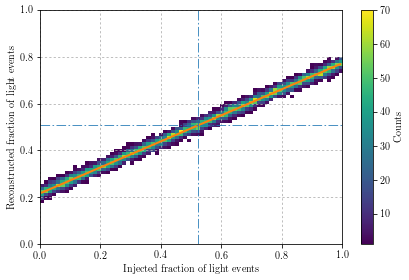

In [47]:
fig, ax = plt.subplots()
frac_bins = np.linspace(0.0, 1.0, 75)
plotting.histogram_2D(injected_frac, reco_frac, bins=frac_bins, ax=ax)
ax.plot(frac_midpoints, linefit_response(frac_midpoints), marker='None',
        ls='-', lw=2, color='C1')
ax.axhline(frac_light, marker='None', ls='-.')
ax.axvline(inverse_response(frac_light), marker='None', ls='-.')
print(inverse_response(frac_light))
ax.set_xlabel('Injected fraction of light events')
ax.set_ylabel('Reconstructed fraction of light events')
ax.grid()
plt.savefig('/home/jbourbeau/public_html/figures/light-frac-reconstructed-2d.png')
plt.show()

In [24]:
reco_frac_std = stats.binned_statistic(reco_frac, injected_frac, bins=frac_bins, statistic=np.std)[0]
print(reco_frac_std)
frac_midpoints = (frac_bins[1:] + frac_bins[:-1]) / 2
linefit = lambda x, b: b
x = frac_midpoints[(frac_midpoints > 0.3) & (frac_midpoints < 0.7)]
y = reco_frac_std[(frac_midpoints > 0.3) & (frac_midpoints < 0.7)]
popt, pcov = optimize.curve_fit(linefit, x, y)
intercept = popt[0]
print(intercept)
yfit = linefit(x, intercept)
yfit = np.array([yfit for i in range(len(x))])

[        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan  0.          0.00705656  0.01009688  0.01775529  0.0218893
  0.02278631  0.02490347  0.02402943  0.02481538  0.02403843  0.02376505
  0.02400733  0.02449618  0.02429567  0.02317209  0.02334606  0.02402929
  0.02575662  0.02612274  0.02369656  0.02232409  0.02518269  0.02308029
  0.02432504  0.02491382  0.02631043  0.0253621   0.0236952   0.02642021
  0.02360639  0.02465072  0.02482334  0.02246951  0.02487805  0.02375854
  0.02489142  0.02423951  0.02661511  0.02482411  0.02574868  0.02436697
  0.0228967   0.02014996  0.01931386  0.01411594  0.01043543         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan]
0.0244365530609


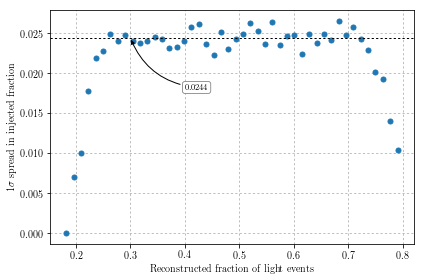

In [25]:
fig, ax = plt.subplots()
ax.plot(frac_midpoints, reco_frac_std, ls='None', ms=10)
ax.axhline(intercept, marker='None', lw=1, ls=':', color='k')
ax.annotate('{:.4f}'.format(intercept), xy=(0.3, intercept), xytext=(0.4, 0.018),
            arrowprops=dict(arrowstyle='-|>', color='black', connectionstyle='arc3,rad=-0.3'), fontsize=8,
            bbox=dict(boxstyle='round', fc="white", ec="gray", lw=0.8))
ax.grid()
ax.set_xlabel('Reconstructed fraction of light events')
ax.set_ylabel('1$\sigma$ spread in injected fraction')
plt.savefig('/home/jbourbeau/public_html/figures/light-frac-reconstructed-spread.png')
plt.show()